# import libraries

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import itertools  
import math
import itertools
from sklearn.model_selection import train_test_split

import keras
from keras.layers import Dense, Input, Dropout, Flatten
from keras.layers import LSTM, Embedding, Bidirectional
from keras.models import Model
from keras.initializers import Constant
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras.callbacks import History 
from keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn import metrics
from keras.regularizers import l2
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report 

import tensorflow as tf

Using TensorFlow backend.


## reading data to be trained

In [2]:
# reading data from csv files

path = r'C:\Users\91901\Code Here\CQA\dataset\Subtask B'

train_base = pd.read_csv(os.path.join(path,'TRAIN-BASE.csv'))
test_base = pd.read_csv(os.path.join(path,'TEST-BASE.csv'))
val_base = pd.read_csv(os.path.join(path,'VAL-BASE.csv'))

def read_df(df):
    f = df['feature'].tolist()
    x = df['question'].tolist()
    xx = df['rel_question'].tolist()
    y = df['labels'].tolist()
    return f, x, xx, y

f_train, x_train, xx_train, y_train = read_df(train_base)
f_test, x_test, xx_test, y_test = read_df(test_base)
f_val, x_val, xx_val, y_val = read_df(val_base)

# PRINT AND CHECK TRAINING, TESTING AND VALIDATION SET

print('\nTraining: ', len(f_train), len(x_train), len(xx_train), len(y_train)) #must be same
print('\nTesting: ', len(f_test), len(x_test), len(xx_test), len(y_test))
print('\nValidation: ', len(f_val), len(x_val), len(xx_val), len(y_val))


Training:  1958 1958 1958 1958

Testing:  684 684 684 684

Validation:  495 495 495 495


In [3]:
train_base.head()

,feature,question,rel_question,labels
0,Massage oil massage oil,Where I can buy good oil for massage?,is there any place i can find scented massage ...,PerfectMatch
1,Massage oil Philipino Massage center,Where I can buy good oil for massage?,Hi;Can any one tell me a place where i can hav...,Relevant
2,Massage oil Best place for massage,Where I can buy good oil for massage?,Tell me; where is the best place to go for a m...,Irrelevant
3,Massage oil body massage,Where I can buy good oil for massage?,hi there; i can see a lot of massage center he...,Relevant
4,Massage oil What attracts you more ?,Where I can buy good oil for massage?,What attracts you more ?,Irrelevant


# UPSAMPLING (training, validation) and RE-MAKE all Test sets using train-test-split()

Upsampled Training Data and Validation Data. Combined these with given Test Data. Made new Training, Testing sets using sklearn. Validation Split 0.50 added in model.fit() 

In [4]:
# # SAMPLING ACCORDING TO LABELS 


feature_train, ques_train, relq_train, train_labels = f_train, x_train, xx_train, y_train
feature_test, ques_test, relq_test, test_labels = f_test, x_test, xx_test, y_test
feature_val, ques_val, relq_val, val_labels = f_val, x_val, xx_val, y_val


train_base = pd.DataFrame(
    {
    'feature':feature_train ,
    'question':ques_train,
    'rel_question': relq_train,
    'labels':train_labels
    })

test_base = pd.DataFrame(
    {
    'feature':feature_test ,
    'question':ques_test,
    'rel_question':relq_test,
    'labels':test_labels
    })

val_base = pd.DataFrame(
    {
    'feature':feature_val ,
    'question':ques_val,
    'rel_question':relq_val,
    'labels':val_labels
    })

In [5]:
# if one function for all train, test, validation 
def oversampling_function(base):

    bad_count, good_count, useful_count = base['labels'].value_counts()
    
    class_0 = base[base['labels'] == 'Irrelevant']
    class_1 = base[base['labels'] == 'Relevant']
    class_2 = base[base['labels'] == 'PerfectMatch']

    ## print the shape of the class
    
    print('\n\nclass bad 0:', class_0.shape)
    print('class useful 1:', class_1.shape)
    print('class good 2:', class_2.shape)
    
    
    ## OVERSAMPLNG
    
    class_good = class_2.sample(bad_count, replace=True)
    class_useful = class_1.sample(bad_count, replace=True)

    oversampled_base = pd.concat([class_0, class_useful, class_good], axis = 0)
    print("Oversampled - Total class counts:\n", oversampled_base['labels'].value_counts())

#     print(oversampled_base['labels'].value_counts().plot(kind='bar', title = 'count (labels)'))

    return oversampled_base


print("Upsampling training Pool")
train_pool = oversampling_function(train_base)
val_pool = oversampling_function(val_base)
test_pool = test_base
#NEW TRAINING, TESTING, VALIDATION SET SIZES

print("\ntraining pool size after upsampling:", train_pool.shape)
print("\nvalidation pool size after upsampling:",val_pool.shape)
print("\ntesting pool size after upsampling:",test_pool.shape)

Upsampling training Pool


class bad 0: (1191, 4)
class useful 1: (592, 4)
class good 2: (175, 4)
Oversampled - Total class counts:
 Irrelevant      1191
Relevant        1191
PerfectMatch    1191
Name: labels, dtype: int64


class bad 0: (283, 4)
class useful 1: (153, 4)
class good 2: (59, 4)
Oversampled - Total class counts:
 Relevant        283
Irrelevant      283
PerfectMatch    283
Name: labels, dtype: int64

training pool size after upsampling: (3573, 4)

validation pool size after upsampling: (849, 4)

testing pool size after upsampling: (684, 4)


In [6]:
#combine train, validation
train_pool =  train_pool.append(val_pool, ignore_index = True) #combine train and validation pool
print("total training data now:\n ", len(train_pool))

total training data now:
  4422


In [7]:
# TRAINING, VALIDATION, TESTING SETS


frames = [train_pool, test_pool, val_pool]
BASE = pd.concat(frames)
BASE.shape
BASE.labels.value_counts()

#%%

a, b = train_test_split(BASE, test_size = 0.5)

f_train, x_train, xx_train, y_train = a['feature'], a['question'], a['rel_question'], a['labels']
f_test, x_test, xx_test, y_test = b['feature'], b['question'], b['rel_question'], b['labels']

# PRINT AND CHECK TRAINING, TESTING AND VALIDATION SET

print('\nTraining: ', len(f_train), len(x_train), len(xx_train), len(y_train)) #must be same
print('\nTesting: ', len(f_test), len(x_test), len(xx_test), len(y_test))



Training:  2977 2977 2977 2977

Testing:  2978 2978 2978 2978


# let's read and make embeddings for data

In [8]:
# avg_feature_length = avg_question_length = avg_answer_length = 
MAX_SEQUENCE_LENGTH = FINAL_SEQUENCE_LENGTH = 50

In [9]:
# FOR GLOVE VECTORS

def read_glove_vecs(GLOVE_DIR, EMBEDDING_DIM):
    
    with open(os.path.join(GLOVE_DIR, 'glove.6B.'+ str(EMBEDDING_DIM)+'d.txt'),  encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map


def pretrained_embedding_layer(word_to_vec_map, word_to_index, random_term):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map[random_term].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    ### START CODE HERE ###
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. 
    # Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable = False)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

# GLOVE_DIR = 'glove.6B'
# GLOVE_DIR = r'C:\Users\NoBotsHere\codehere\CQACodes\qa_dataset\glove.6B'
GLOVE_DIR = r'C:\Users\91901\Code Here\CQA\dataset\glove.6B'

EMBEDDING_DIM = 50
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs(GLOVE_DIR, EMBEDDING_DIM)
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index, "massage")

In [10]:
def generate_data_for_keras( t1, t2, t3, Y,
#                             X, Y, 
                            word_index):

    t1_sequences = [] #first vector 
    t2_sequences = [] #second vector
    t3_sequences = [] #three vector
    
    for t1_keys in t1:
        t1_sequences.append([word_index[i] if i in word_index.keys() else 0 for i in t1_keys.lower().split()])
    
    for t2_keys in t2:
        t2_sequences.append([word_index[i] if i in word_index.keys() else 0 for i in t2_keys.lower().split()])
#     print(t2_sequences[:10])
    
    for t3_keys in t3:
        t3_sequences.append([word_index[i] if i in word_index.keys() else 0 for i in t3_keys.lower().split()])
#     print(t3_sequences[:10])       
    
    # padding 
    # long sentences truncated to maxlen (last sequences are kept)
    # short sentences padded with 0 (pad are added at begining)
    t1_data = pad_sequences(t1_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')   # if separate features, add dtype = 'object'
    t2_data = pad_sequences(t2_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post') 
    t3_data = pad_sequences(t3_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post') 

    print('\nShape of feature text data tensor:', t1_data.shape)
    print('\nShape of question1 text data tensor:', t2_data.shape)
    print('\nShape of question2 text data tensor:', t3_data.shape)
 
    
    y = []
    
    for t in Y:    
        if t =='Irrelevant':
            y.append(0)
        elif t =='PerfectMatch':
            y.append(2)
        elif t == 'Relevant':
            y.append(1)
    
    print('\nShape of label data tensor:', np.array(y).shape)
    
    label = np.array(y)
    print('\nlabel data:', label[:10])
    
    return t1_data, t2_data, t3_data, label


# # data for keras layers
#T1 IS FIRST TEXT FEATURE TEXT
#T2 IS QUESTION TEXT 
#T3 IS related question TEXT
print('\nTraining: ') 
t1_train, t2_train, t3_train, y_train  = generate_data_for_keras(f_train, x_train, xx_train, y_train, word_to_index)

print('\nTesting: ')
t1_test, t2_test, t3_test, y_test  = generate_data_for_keras(f_test, x_test, xx_test, y_test, word_to_index)

print('\nTraining: ', len(t1_train), len(t2_train), len(t3_train), len(y_train)) #must be same
print('\nTesting: ', len(t1_test), len(t2_test), len(t3_test), len(y_test))



Training: 

Shape of feature text data tensor: (2977, 50)

Shape of question1 text data tensor: (2977, 50)

Shape of question2 text data tensor: (2977, 50)

Shape of label data tensor: (2977,)

label data: [2 0 2 0 0 2 0 1 2 1]

Testing: 

Shape of feature text data tensor: (2978, 50)

Shape of question1 text data tensor: (2978, 50)

Shape of question2 text data tensor: (2978, 50)

Shape of label data tensor: (2978,)

label data: [2 1 0 2 1 0 2 2 0 1]

Training:  2977 2977 2977 2977

Testing:  2978 2978 2978 2978


In [11]:
# DISPLAY training, testing and validation data 

print('------- Training Data -------\n')
for i in range (2):
    print ('Entry:', t1_train[i] , '\n', t2_train[i] , '\n', t3_train[i] , '\nLabel:' , y_train[i], '\n')
      
print('------- Testing Data -------\n')
for i in range (2):
    print ('Entry:', t1_test[i] , '\n', t2_test[i] , '\n', t3_test[i] , '\nLabel:' , y_test[i], '\n')


------- Training Data -------

Entry: [     0 185457 105625  65680 360915 296552  47798 148538 254258      0
 388711 270970 388756 262487      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0] 
 [185457 148534 254258 108200 217787 393302 188481      0 185457 302790
 357266 220941 268046      0      0 154323 254258      0  90548 185457
 105625  65680 360915 296552  47798  21828 249167  54718 389836 151349
 357266 316998      0 394565  56165      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0] 
 [185457 105625  65680 188481 220815 357109  43010 393302 270970      0
      0 175426 357212 186645 389883 177231 188481 296552 151349 249714
 357109  15341 393335 394475  90548 105625  65680 188481 219145 357109
  43010 393302 388756 174695  542

# Preparing Contextualized Embeddings

In [12]:
%%time

# Prepare embeddings sequences by initializing keras embedding layer with glove embedding values

sequence_input_feat = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name='featureLayer')
embedded_feat_sequences = embedding_layer(sequence_input_feat)
      
sequence_input_ques = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name='questionLayer')
embedded_ques_sequences = embedding_layer(sequence_input_ques)


sequence_input_ans = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name='relQuestionLayer')
embedded_ans_sequences = embedding_layer(sequence_input_ans)

Wall time: 150 ms


In [13]:
%%time

def bilstm_embeddings(embedded_sequences):

   
    n = Bidirectional(LSTM(nn_units, return_sequences= True, 
                            name = 'bilstm_layer', dropout = dropout_inputs, 
                            recurrent_dropout = recurrent_dropout_inputs))(embedded_sequences)

    return n

Wall time: 0 ns


# Model definition for Classification


In [14]:
# default helpful

INPUT_SEQUENCES = [sequence_input_feat, sequence_input_ques, sequence_input_ans]
TRAIN_FIT = [t1_train, t2_train, t3_train]

In [15]:
# defining model

def classification_model(INPUT_EMBEDDINGS, INPUT_SEQUENCES):
    
    # FOR MODEL_1 
    
    FinalLayer = keras.layers.concatenate(inputs = INPUT_EMBEDDINGS, axis = 1)
    FinalLayer = keras.layers.GlobalAveragePooling1D()(FinalLayer)
    predictions = Dense(3, activation = "softmax")(FinalLayer)


    model = Model(inputs = INPUT_SEQUENCES , outputs = predictions)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])
    
    model.summary()

    return model

# Common functions - Plot, Evaluate, Save Results

# Training Model

In [16]:
def training_model(model, MODEL_NAME, TRAIN_FIT):
    

    callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 5)
    checkpoint_path = os.path.join(MODEL_NAME + '_checkpoint.h5')

    modelcheck_acc = ModelCheckpoint(checkpoint_path, 
                                     monitor='acc', mode='max', 
                                    save_best_only = True, verbose=1)

    CALLBACK = [callback, modelcheck_acc]

    history = model.fit(TRAIN_FIT, y_train, 
                            batch_size = batchsize, 
                            epochs = epochs_count, 
                            validation_split = 0.50, 
                            callbacks = CALLBACK
                           )
    return history

In [17]:
# into files save
  
# model_directory = "Resulting Model"
# MODEL_SAVING_DIR = os.path.join(path, model_directory)
# os.mkdir(MODEL_SAVING_DIR) 
 
# MODEL_SAVING_DIR = (r'\folder-path')

def save_models(model, MODEL_NAME):
  
    # serialize model to JSON
    model_json = model.to_json()
    with open(MODEL_NAME + ".json", "w") as json_file:
        json_file.write(model_json)

    # serialize weights to HDF5
    model.save_weights(MODEL_NAME + ".h5")
    print("\nTHIS MODEL HAS BEEN SAVED TO DIRECTORY: ", os.getcwd())

In [18]:
def plot_graphs(history, string):
    print('training of model')
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

In [19]:
def plot_both_graphs(history):
    # plot train and validation loss
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    # plot train and validation loss
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model train vs validation acc')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    

In [20]:
def evaluate_model(model):
    # Returns the loss value & metrics values for the model in test mode.
    print("Evaluated on metrics ", model.metrics_names)

    score_loss, score_acc = model.evaluate([t1_test, t2_test, t3_test], y_test, batch_size=batchsize)
    print("Test Loss :", score_loss, "Test Accuracy: ", score_acc)

    # MODEL_1 FOR PREDICTIONS 
    model_predictions = model.predict([t1_test, t2_test, t3_test])
    print("\npredictions shape is: ", model_predictions.shape)
#     print("\nand few predictions are:\n", model_predictions[:3], "\n\n while original test labels look like: ", y_test[:10])

    #To find the predicted class for each test example, you need to use axis=1
    predicted_class_names = np.argmax(model_predictions, axis = 1)
    print("\n\n Predictions into Class Labels:", predicted_class_names)

    print("\n\n METRICS CLASSIFICATION REPORT IS:\n", classification_report (y_test, np.argmax(model_predictions, axis = 1)))
    
    return model_predictions, predicted_class_names

In [21]:
def result_store(predicted_class_names):
    
    df = pd.DataFrame(columns = ['feature', 'text_1', 'text_2', 'true_label'])
    df['feature'] = f_test
    df['text_1'] = x_test
    df['text_2'] = xx_test
    df['true_label'] = y_test
    df['predicted_label'] = predicted_class_names

    return df

In [22]:
## put into files these 


# df_true_labels = pd.DataFrame(y_test, columns = ['y_test_labels'])
# df_true_labels.y_test_labels.value_counts()
# df_true_labels.head()

# df_pred_labels = pd.DataFrame(predicted_class_names_1, columns = ['y_pred_labels'])
# df_pred_labels.y_pred_labels.value_counts()
# df_pred_labels.head()

# print("no of true labels:\n", df_true_labels.y_test_labels.value_counts())
# print("no of predicted labels:\n", df_pred_labels.y_pred_labels.value_counts())

## Model_bilstm for Classification

In [23]:
# define parameters 

nn_units = 128
dropout_inputs = 0.2
recurrent_dropout_inputs = 0.15
batchsize = 64
epochs_count = 100

# call for embeddings

n1 = bilstm_embeddings(embedded_feat_sequences)
n2 = bilstm_embeddings(embedded_ques_sequences)
n3 = bilstm_embeddings(embedded_ans_sequences)

print(n1)
print(n2)
print(n3)

Tensor("bidirectional_1/concat:0", shape=(None, 50, 256), dtype=float32)
Tensor("bidirectional_2/concat:0", shape=(None, 50, 256), dtype=float32)
Tensor("bidirectional_3/concat:0", shape=(None, 50, 256), dtype=float32)


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
featureLayer (InputLayer)       (None, 50)           0                                            
__________________________________________________________________________________________________
questionLayer (InputLayer)      (None, 50)           0                                            
__________________________________________________________________________________________________
relQuestionLayer (InputLayer)   (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 50)       20000050    featureLayer[0][0]               
                                                                 questionLayer[0][0]        

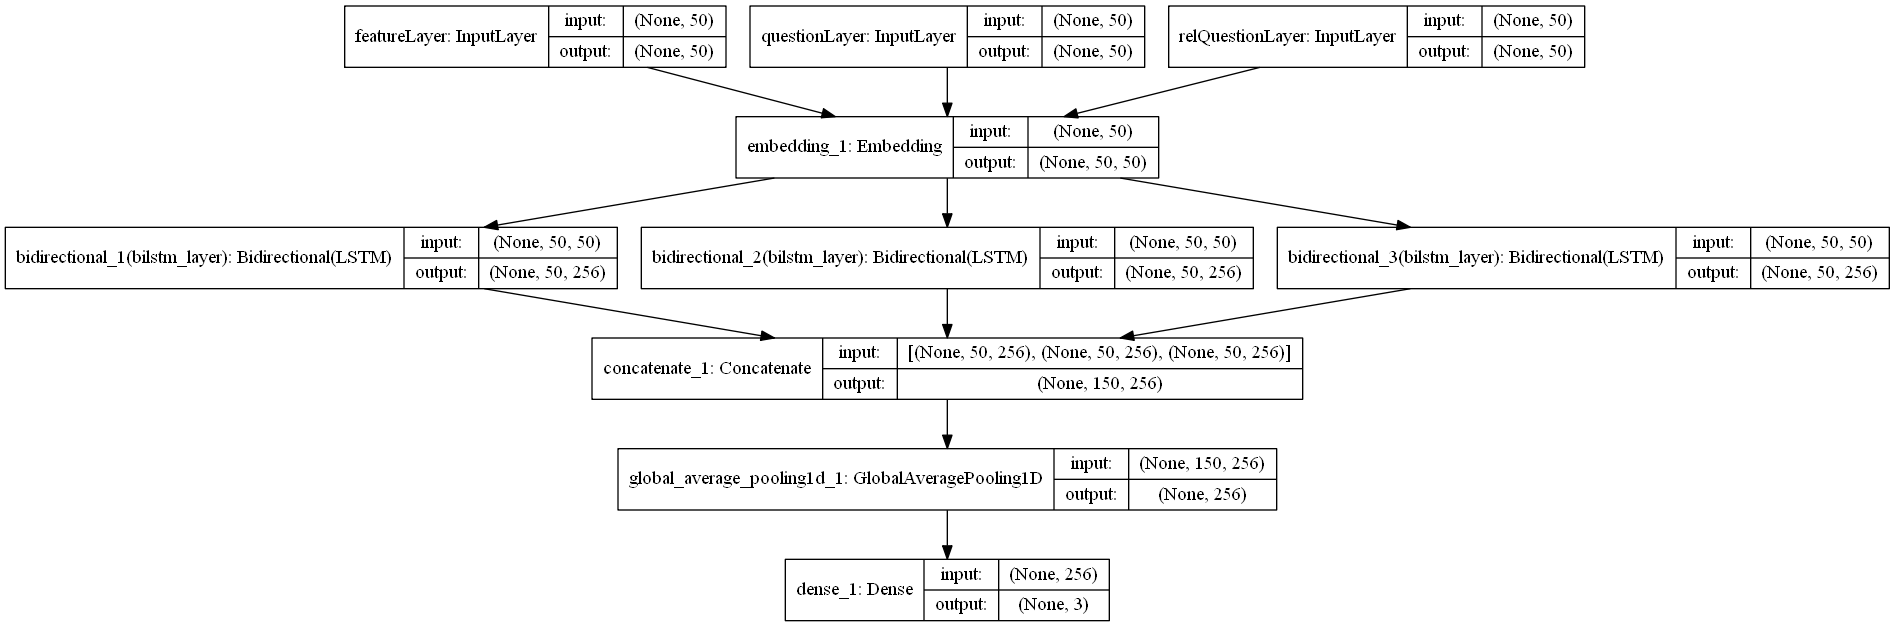

In [24]:
#CUSTOM COLUMNS

INPUT_EMBEDDINGS = [n1, n2, n3]

model_bilstm = classification_model(INPUT_EMBEDDINGS, INPUT_SEQUENCES)
plot_model(model_bilstm, to_file = 's2-model_bilstm.png', show_shapes=True, show_layer_names=True)

In [25]:
history_bilstm = training_model(model_bilstm, 's2-model-bilstm', TRAIN_FIT) 
save_models(model_bilstm, 's2-model-bilstm')

Train on 1488 samples, validate on 1489 samples
Epoch 1/100
1488/1488 [==============================] - 7s 5ms/step - loss: 1.0959 - acc: 0.3690 - val_loss: 1.1178 - val_acc: 0.4056

Epoch 00001: acc improved from -inf to 0.36895, saving model to s2-model-bilstm_checkpoint.h5
Epoch 2/100
1488/1488 [==============================] - 5s 3ms/step - loss: 1.0781 - acc: 0.4160 - val_loss: 1.0762 - val_acc: 0.4271

Epoch 00002: acc improved from 0.36895 to 0.41599, saving model to s2-model-bilstm_checkpoint.h5
Epoch 3/100
1488/1488 [==============================] - 4s 3ms/step - loss: 1.0636 - acc: 0.4382 - val_loss: 1.0541 - val_acc: 0.4822

Epoch 00003: acc improved from 0.41599 to 0.43817, saving model to s2-model-bilstm_checkpoint.h5
Epoch 4/100
1488/1488 [==============================] - 4s 3ms/step - loss: 1.0420 - acc: 0.4637 - val_loss: 1.0430 - val_acc: 0.4929

Epoch 00004: acc improved from 0.43817 to 0.46371, saving model to s2-model-bilstm_checkpoint.h5
Epoch 5/100
1488/1488 [

1488/1488 [==============================] - 4s 3ms/step - loss: 0.3818 - acc: 0.8575 - val_loss: 0.9212 - val_acc: 0.7011

Epoch 00079: acc did not improve from 0.86761
Epoch 80/100
1488/1488 [==============================] - 4s 3ms/step - loss: 0.3481 - acc: 0.8696 - val_loss: 0.9421 - val_acc: 0.6938

Epoch 00080: acc improved from 0.86761 to 0.86962, saving model to s2-model-bilstm_checkpoint.h5
Epoch 81/100
1488/1488 [==============================] - 5s 3ms/step - loss: 0.3479 - acc: 0.8710 - val_loss: 0.9131 - val_acc: 0.7226

Epoch 00081: acc improved from 0.86962 to 0.87097, saving model to s2-model-bilstm_checkpoint.h5
Epoch 82/100
1488/1488 [==============================] - 4s 3ms/step - loss: 0.3365 - acc: 0.8716 - val_loss: 0.9288 - val_acc: 0.7045

Epoch 00082: acc improved from 0.87097 to 0.87164, saving model to s2-model-bilstm_checkpoint.h5
Epoch 83/100
1488/1488 [==============================] - 4s 3ms/step - loss: 0.3279 - acc: 0.8730 - val_loss: 1.0119 - val_acc:

In [26]:
print(history_bilstm.history['loss'][-1])
print(history_bilstm.history['acc'][-1])

0.2585030963984869
0.90255374


training of model


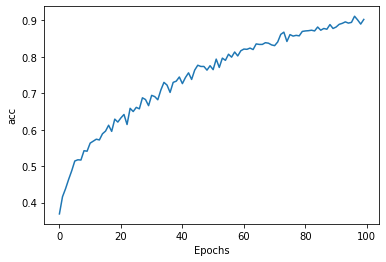

training of model


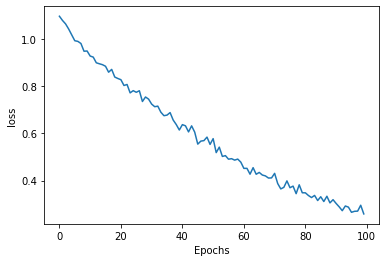

In [27]:
plot_graphs(history_bilstm, 'acc')
plot_graphs(history_bilstm, 'loss')

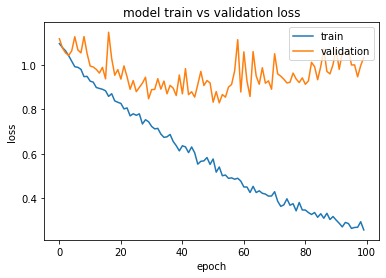

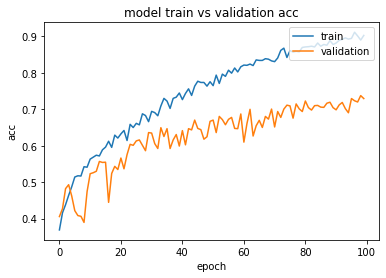

In [28]:
plot_both_graphs(history_bilstm)

In [29]:
model_predictions_bilstm, predicted_class_names_bilstm = evaluate_model(model_bilstm)

Evaluated on metrics  ['loss', 'acc']
2978/2978 [==============================] - 1s 396us/step
Test Loss : 1.0170342919008295 Test Accuracy:  0.7216252684593201

predictions shape is:  (2978, 3)


 Predictions into Class Labels: [2 0 0 ... 2 1 1]


 METRICS CLASSIFICATION REPORT IS:
               precision    recall  f1-score   support

           0       0.70      0.73      0.72      1071
           1       0.70      0.56      0.62       977
           2       0.76      0.87      0.82       930

    accuracy                           0.72      2978
   macro avg       0.72      0.72      0.72      2978
weighted avg       0.72      0.72      0.72      2978



In [30]:
result_bilstm = result_store(predicted_class_names_bilstm)

print("no of true labels:\n", result_bilstm.true_label.value_counts())
print("no of predicted labels:\n", result_bilstm.predicted_label.value_counts())

result_bilstm.head()

no of true labels:
 0    1071
1     977
2     930
Name: true_label, dtype: int64
no of predicted labels:
 0    1126
2    1064
1     788
Name: predicted_label, dtype: int64


,feature,text_1,text_2,true_label,predicted_label
4301,Nursing license requirements? Experience neces...,I am a male nurse;passed qatar prometric exam ...,Hello guys..I want to take NHA licensure(Nurse...,2,2
1869,"""Can I come back to Qatar after finishing my c...",I finished my contract last year in Qatar. I r...,Hello; Could anyone help to clarify what spons...,1,0
1109,Any one know the Bicycle servicing shops in Do...,Please tell me any bicycle repairing shops or ...,Hi; Are there any Bike shops in Doha? Not top ...,0,0
2467,visa transfer from husband to campany visa Wif...,Any one can help me; is it possible to transfe...,If your wife / husband under family sponsorshi...,2,2
2164,No Work Visa for Ladies Visa cancellation with...,Hi; Just wanted to know why most of the compan...,Can my sponsor cancel my visa even without my ...,1,0


In [31]:
result_bilstm.sort_index()

,feature,text_1,text_2,true_label,predicted_label
0,Good Bank Best Bank,Which is a good bank as per your experience in...,Hi Guys; I need to open a new bank accoount. W...,2,2
0,Massage oil Best place for massage,Where I can buy good oil for massage?,Tell me; where is the best place to go for a m...,0,2
0,Good Bank Best Bank,Which is a good bank as per your experience in...,Hi Guys; I need to open a new bank accoount. W...,2,2
1,Good Bank What is the best bank to open an acc...,Which is a good bank as per your experience in...,Seems like all the banks need the salary to be...,2,2
1,Good Bank What is the best bank to open an acc...,Which is a good bank as per your experience in...,Seems like all the banks need the salary to be...,2,2
...,...,...,...,...,...
4412,Where is Pajju?? Pajju,i don't use much qatar living; but still i vis...,Where is my friend Pajju; long time didnt see ...,2,2
4414,What's going on during Eid? Things to do in Qa...,I know Katara is having fireworks during Eid b...,Hey! My husband and I have a week off next wee...,2,2
4415,Child safety seats Car seats,salaam-hello can anyone tell me what are the l...,What carseat brands are available in Qatar? IÂ...,2,2
4419,Does anyone home school their children? home s...,We are struggling to find a school place and a...,With all the long waiting lists for children g...,2,2


In [32]:
results_path = os.getcwd()
result_bilstm.to_csv(os.path.join(results_path,'s2-FQQ-BILSTM-CLASSIFIED.csv'), index_label = False, index = False)

# Stacked Model

In [34]:
# define parameters for stacked

nn_units = 64
dropout_inputs = 0.3
recurrent_dropout_inputs = 0.2
batchsize = 32
epochs_count = 80

# call for embeddings

n1 = bilstm_embeddings(embedded_feat_sequences)
n2 = bilstm_embeddings(embedded_ques_sequences)
n3 = bilstm_embeddings(embedded_ans_sequences)

print(n1)
print(n2)
print(n3)

Tensor("bidirectional_4/concat:0", shape=(None, 50, 128), dtype=float32)
Tensor("bidirectional_5/concat:0", shape=(None, 50, 128), dtype=float32)
Tensor("bidirectional_6/concat:0", shape=(None, 50, 128), dtype=float32)


In [35]:
%%time


# call for stacked embeddings

def stacked_bilstm_embeddings(layer):
    
    for i in range(4):
#         print('run:', i, '--', 'layer-name:', layer)
        layer = Bidirectional(LSTM(nn_units, return_sequences= True, name = 'bilstm_layer', 
                        dropout=dropout_inputs, recurrent_dropout = recurrent_dropout_inputs))(layer)
    
    return layer

stacked_n1 = stacked_bilstm_embeddings(n1)
stacked_n2 = stacked_bilstm_embeddings(n2)
stacked_n3 = stacked_bilstm_embeddings(n3)

print(stacked_n1)
print(stacked_n2)
print(stacked_n3)

Tensor("bidirectional_10/concat:0", shape=(None, 50, 128), dtype=float32)
Tensor("bidirectional_14/concat:0", shape=(None, 50, 128), dtype=float32)
Tensor("bidirectional_18/concat:0", shape=(None, 50, 128), dtype=float32)
Wall time: 5.22 s


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
featureLayer (InputLayer)       (None, 50)           0                                            
__________________________________________________________________________________________________
questionLayer (InputLayer)      (None, 50)           0                                            
__________________________________________________________________________________________________
relQuestionLayer (InputLayer)   (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 50)       20000050    featureLayer[0][0]               
                                                                 questionLayer[0][0]        

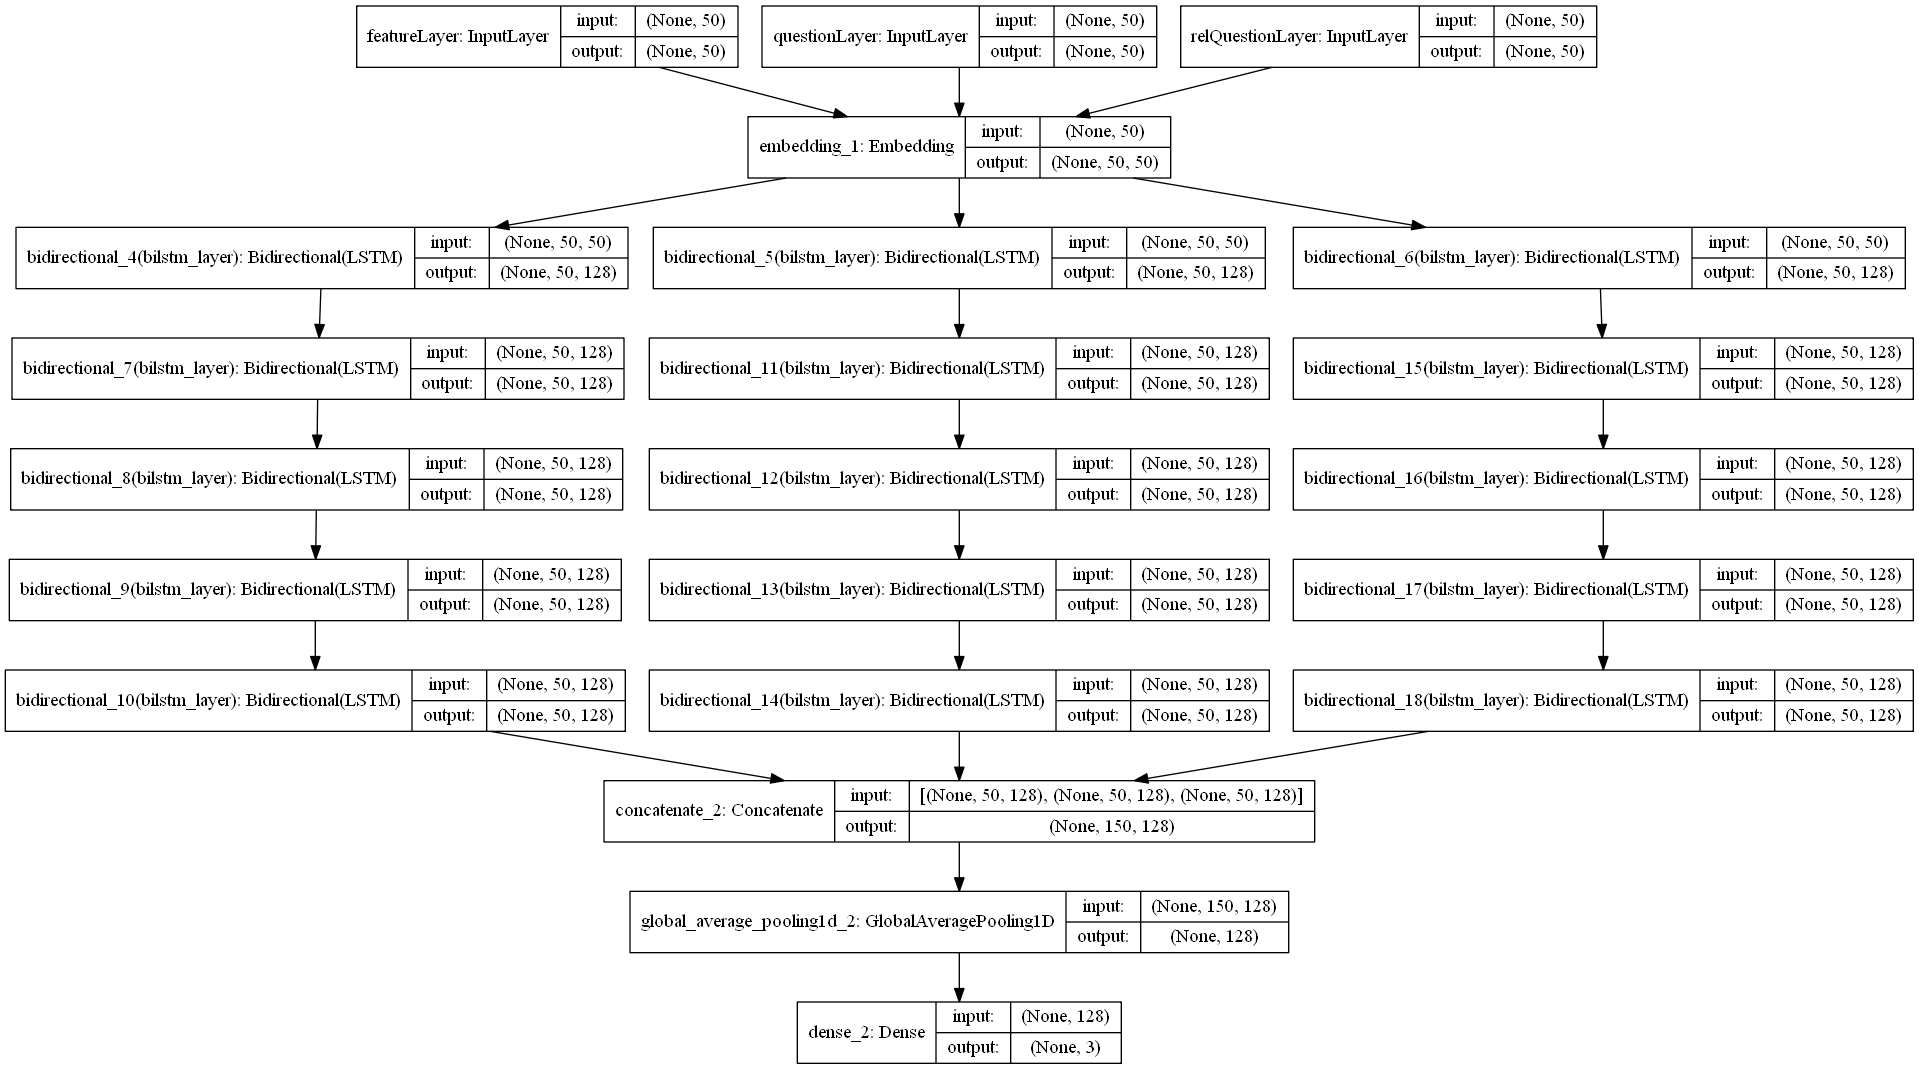

In [36]:
STACKED_EMBEDDINGS = [stacked_n1, stacked_n2, stacked_n3]

model_stacked_bilstm = classification_model(STACKED_EMBEDDINGS, INPUT_SEQUENCES)
plot_model(model_stacked_bilstm, to_file = 's2-model_stacked_bilstm.png', show_shapes=True, show_layer_names=True)

In [37]:
history_stacked_bilstm = training_model(model_stacked_bilstm, 's2-model-stacked-bilstm', TRAIN_FIT) 

Train on 1488 samples, validate on 1489 samples
Epoch 1/80
1488/1488 [==============================] - 57s 38ms/step - loss: 1.0998 - acc: 0.3669 - val_loss: 1.0927 - val_acc: 0.3895

Epoch 00001: acc improved from -inf to 0.36694, saving model to s2-model-stacked-bilstm_checkpoint.h5
Epoch 2/80
1488/1488 [==============================] - 48s 32ms/step - loss: 1.0893 - acc: 0.3770 - val_loss: 1.0967 - val_acc: 0.4036

Epoch 00002: acc improved from 0.36694 to 0.37702, saving model to s2-model-stacked-bilstm_checkpoint.h5
Epoch 3/80
1488/1488 [==============================] - 47s 32ms/step - loss: 1.0776 - acc: 0.4167 - val_loss: 1.0882 - val_acc: 0.4124

Epoch 00003: acc improved from 0.37702 to 0.41667, saving model to s2-model-stacked-bilstm_checkpoint.h5
Epoch 4/80
1488/1488 [==============================] - 50s 33ms/step - loss: 1.0384 - acc: 0.4664 - val_loss: 1.0525 - val_acc: 0.4506

Epoch 00004: acc improved from 0.41667 to 0.46640, saving model to s2-model-stacked-bilstm_c

Epoch 37/80
1488/1488 [==============================] - 47s 32ms/step - loss: 0.7767 - acc: 0.6539 - val_loss: 0.9270 - val_acc: 0.5937

Epoch 00037: acc did not improve from 0.65793
Epoch 38/80
1488/1488 [==============================] - 46s 31ms/step - loss: 0.7703 - acc: 0.6613 - val_loss: 0.9085 - val_acc: 0.6206

Epoch 00038: acc improved from 0.65793 to 0.66129, saving model to s2-model-stacked-bilstm_checkpoint.h5
Epoch 39/80
1488/1488 [==============================] - 52s 35ms/step - loss: 0.7448 - acc: 0.6815 - val_loss: 0.9224 - val_acc: 0.6253

Epoch 00039: acc improved from 0.66129 to 0.68145, saving model to s2-model-stacked-bilstm_checkpoint.h5
Epoch 40/80
1488/1488 [==============================] - 55s 37ms/step - loss: 0.7144 - acc: 0.6882 - val_loss: 0.8978 - val_acc: 0.6380

Epoch 00040: acc improved from 0.68145 to 0.68817, saving model to s2-model-stacked-bilstm_checkpoint.h5
Epoch 41/80
1488/1488 [==============================] - 56s 37ms/step - loss: 0.7287 -

1488/1488 [==============================] - 46s 31ms/step - loss: 0.4847 - acc: 0.7957 - val_loss: 0.9180 - val_acc: 0.6716

Epoch 00075: acc did not improve from 0.80712
Epoch 76/80
1488/1488 [==============================] - 46s 31ms/step - loss: 0.4862 - acc: 0.8091 - val_loss: 0.9002 - val_acc: 0.6884

Epoch 00076: acc improved from 0.80712 to 0.80914, saving model to s2-model-stacked-bilstm_checkpoint.h5
Epoch 77/80
1488/1488 [==============================] - 46s 31ms/step - loss: 0.4781 - acc: 0.8038 - val_loss: 0.9852 - val_acc: 0.6729

Epoch 00077: acc did not improve from 0.80914
Epoch 78/80
1488/1488 [==============================] - 46s 31ms/step - loss: 0.4678 - acc: 0.8112 - val_loss: 0.9037 - val_acc: 0.6877

Epoch 00078: acc improved from 0.80914 to 0.81116, saving model to s2-model-stacked-bilstm_checkpoint.h5
Epoch 79/80
1488/1488 [==============================] - 46s 31ms/step - loss: 0.4644 - acc: 0.8091 - val_loss: 0.8839 - val_acc: 0.7025

Epoch 00079: acc did

In [38]:
save_models(model_stacked_bilstm, 's2-model_stacked_bilstm')


THIS MODEL HAS BEEN SAVED TO DIRECTORY:  C:\Users\91901\Code Here\CQA\1 go-to files functions\task-B


training of model


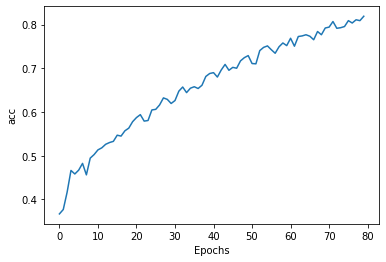

training of model


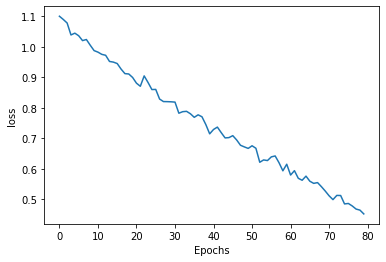

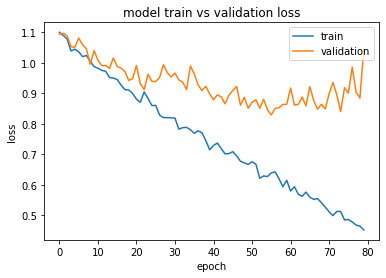

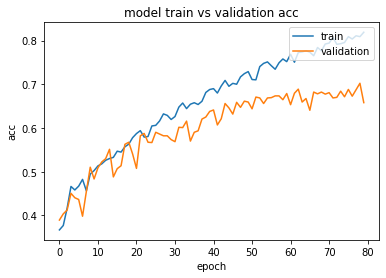

In [39]:
plot_graphs(history_stacked_bilstm, 'acc')
plot_graphs(history_stacked_bilstm, 'loss')
plot_both_graphs(history_stacked_bilstm)

In [40]:
model_predictions_stacked_bilstm, predicted_class_names_stacked_bilstm = evaluate_model(model_stacked_bilstm)

Evaluated on metrics  ['loss', 'acc']
2978/2978 [==============================] - 10s 3ms/step
Test Loss : 1.0073384099394143 Test Accuracy:  0.6537944674491882

predictions shape is:  (2978, 3)


 Predictions into Class Labels: [2 0 2 ... 2 1 2]


 METRICS CLASSIFICATION REPORT IS:
               precision    recall  f1-score   support

           0       0.75      0.51      0.61      1071
           1       0.56      0.61      0.58       977
           2       0.68      0.87      0.76       930

    accuracy                           0.65      2978
   macro avg       0.66      0.66      0.65      2978
weighted avg       0.67      0.65      0.65      2978



In [41]:
result_stacked_bilstm = result_store(predicted_class_names_stacked_bilstm)

print("no of true labels:\n", result_stacked_bilstm.true_label.value_counts())
print("no of predicted labels:\n", result_stacked_bilstm.predicted_label.value_counts())

result_stacked_bilstm.head()

no of true labels:
 0    1071
1     977
2     930
Name: true_label, dtype: int64
no of predicted labels:
 2    1189
1    1064
0     725
Name: predicted_label, dtype: int64


,feature,text_1,text_2,true_label,predicted_label
4301,Nursing license requirements? Experience neces...,I am a male nurse;passed qatar prometric exam ...,Hello guys..I want to take NHA licensure(Nurse...,2,2
1869,"""Can I come back to Qatar after finishing my c...",I finished my contract last year in Qatar. I r...,Hello; Could anyone help to clarify what spons...,1,0
1109,Any one know the Bicycle servicing shops in Do...,Please tell me any bicycle repairing shops or ...,Hi; Are there any Bike shops in Doha? Not top ...,0,2
2467,visa transfer from husband to campany visa Wif...,Any one can help me; is it possible to transfe...,If your wife / husband under family sponsorshi...,2,2
2164,No Work Visa for Ladies Visa cancellation with...,Hi; Just wanted to know why most of the compan...,Can my sponsor cancel my visa even without my ...,1,1


In [42]:
results_path = os.getcwd() 
result_stacked_bilstm.to_csv(os.path.join(results_path,'s2-FQQ-STACKED-BILSTM-CLASSIFIED.csv'), index_label = False, index = False)

In [43]:
t = result_stacked_bilstm.sort_index()

In [44]:
t.head(50)

,feature,text_1,text_2,true_label,predicted_label
0,Good Bank Best Bank,Which is a good bank as per your experience in...,Hi Guys; I need to open a new bank accoount. W...,2,2
0,Massage oil Best place for massage,Where I can buy good oil for massage?,Tell me; where is the best place to go for a m...,0,2
0,Good Bank Best Bank,Which is a good bank as per your experience in...,Hi Guys; I need to open a new bank accoount. W...,2,2
1,Good Bank What is the best bank to open an acc...,Which is a good bank as per your experience in...,Seems like all the banks need the salary to be...,2,2
1,Good Bank What is the best bank to open an acc...,Which is a good bank as per your experience in...,Seems like all the banks need the salary to be...,2,2
1,Massage oil What attracts you more ?,Where I can buy good oil for massage?,What attracts you more ?,0,2
2,"""IT Jobs in Qatar Are Indians really getting j...","""""how hard is it for you to get a decent payin...",I am coming to qatar in visit visa coming week...,1,0
2,Massage oil You have got to be joking.....Seen...,Where I can buy good oil for massage?,[img_assist|nid=54388|title=Placenta cream ???...,0,0
2,Good Bank Which Bank to use in Qatar?,Which is a good bank as per your experience in...,Hi Does anyone have recommendations for which ...,2,2
2,Good Bank Which Bank to use in Qatar?,Which is a good bank as per your experience in...,Hi Does anyone have recommendations for which ...,2,2
